# Evaluate commuter data over time
The code below takes labbeled data, trains a model with a growing amount of training.
Since this is done itaratively and compared to predictions towards a test set an estimation can be made over how fast the model converges.


In [1]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *

#print(df)path="data"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def predict_journeys(learner,dataset):  
    "Return"
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x],pbar=None);
        if (correct==predicted[0]):
            result=result+1
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

def evaluate_learner(rows_per_training:int,trainingset,testset):
    #dataSet = pd.read_csv("data/"+filename,comment="-")
    #datasetTest = pd.read_csv("data/"+testfilename,comment="-")
    result = []
    #size=trainingset.shape[0]
    for rows in range(rows_per_training,len(trainingset),rows_per_training):
        df=trainingset[0:rows]
        idx= list(np.random.randint(0,len(df),int(len(df)*0.1)))
        data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(idx)
                .label_from_df(cols=dep_var)
                .databunch())
        learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
        learner.fit_one_cycle(5)
        sizeR = len(learner.recorder.metrics)
        #run on testset
        resultTest = predict_journeys(learner,testset)
        result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
    return (result)

### How fast in weeks do we get acceptable accuracy (Incremental training)
Below we train models incrementally for each week, based on an estimate number of rows that will be saved for each week (totalrows in dataset/52). 
For this we start from an idelised dataset covering one year of use dataset of the commuter app. The trained model is for every weeks trainng evaluated towards a static test set. 
This test set has the same distribution as the training set and the result is ploted over time 
Deviations compared to a dataset created if the app has been used in reality:
* Training data only includes relevant searches that is part of the users scenarios.
* Test set only includes correct test data.


In [4]:
%%capture
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
testset = pd.read_csv("data/"+user+"_test.csv")
size=trainingset.shape[0]
rows_per_increment = int(size/52) # will result in about one training a week
result = evaluate_learner(rows_per_increment,trainingset,testset)

TypeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/torch_core.py", line 94, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 223, in default_collate
    return torch.LongTensor(batch)
TypeError: an integer is required (got type NoneType)


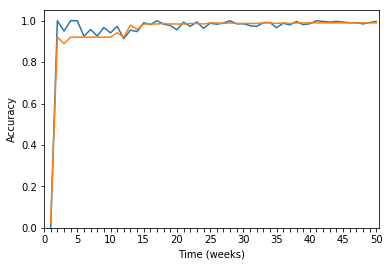

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
result = np.array(result)
##Assuming time for collection one year and linear use
fig, ax = plt.subplots()
ax.plot(result[:,0],result[:,1])
ax.plot(result[:,0],result[:,2])
plt.xlabel('Time (weeks)')
plt.ylabel('Accuracy')
ax.axis([0,size,0.0,1.05])
ax.set_xticks(np.arange(0, size, rows_per_increment))
xs = range(0,size,5*rows_per_increment)
def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return int(tick_val/rows_per_increment)
    else:
        return ''
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
plt.show()

In [10]:
print(result[6:12])

[[8.190000e+02 1.000000e+00 1.000000e+00]
 [9.360000e+02 8.494624e-01 8.666667e-01]
 [1.053000e+03 1.000000e+00 1.000000e+00]
 [1.170000e+03 1.000000e+00 1.000000e+00]
 [1.287000e+03 1.000000e+00 1.000000e+00]
 [1.404000e+03 1.000000e+00 1.000000e+00]]


### Teaching
If an idealised teaching set is created that contains all combinations of categorical columns (activity and weekday) combined with a time placed in the middle of the timespan for the scenario and location at the departure station.

Total time: 00:20
epoch  train_loss  valid_loss  accuracy
1      1.672112    1.768944    0.000000  (00:00)
2      1.666997    1.768010    0.333333  (00:00)
3      1.657752    1.766887    0.333333  (00:00)
4      1.644941    1.765540    0.333333  (00:00)
5      1.628823    1.763979    0.333333  (00:00)
6      1.609754    1.762223    0.333333  (00:00)
7      1.588164    1.760260    0.333333  (00:00)
8      1.564698    1.758001    0.333333  (00:00)
9      1.539975    1.755372    0.333333  (00:00)
10     1.514466    1.752338    0.333333  (00:00)
11     1.488667    1.748729    0.333333  (00:00)
12     1.462444    1.744616    0.333333  (00:00)
13     1.435847    1.739701    0.333333  (00:00)
14     1.408487    1.733901    0.333333  (00:00)
15     1.381358    1.727206    0.166667  (00:00)
16     1.354938    1.719377    0.333333  (00:00)
17     1.328961    1.710278    0.333333  (00:00)
18     1.303555    1.700066    0.333333  (00:00)
19     1.278533    1.689053    0.500000  (00:00)
20     1.25

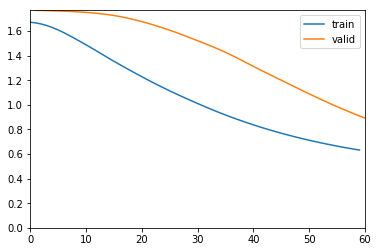

In [2]:
filename = user+"_teaching_set.csv"
dataSet = pd.read_csv("data/"+filename,comment="-")
#idx = np.random.randint(0,len(dataSet),int(len(dataSet)*0.1))
idx= list(np.random.randint(0,len(dataSet),int(len(dataSet)*0.1)))
#idx= list(np.random.randint(0,len(dataSet),2))
rows=dataSet.shape[0]
data = (TabularList.from_df(dataSet, path="saved", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(idx)
                .label_from_df(cols=dep_var)
                #.add_test(datasetTest)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy, callback_fns=ShowGraph)
learner.fit_one_cycle(60,1e-3)
learner.save(user)
#data.export()

If we avaluate this on the test set

In [4]:
%%capture
filenameTest = user+"_test.csv"
datasetTest = pd.read_csv("data/"+filenameTest)
accuracyTest = predict_journeys(learner,datasetTest)

Print result

In [5]:
print(accuracyTest)

1.0


In [5]:
prediction,accuracy = predict_journey(3,1242479403,519,3)
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));

Predicted journey from: 81216 to 80000 with accuracy 0.59


Predict and view some rows

### Misc

### Training on all data


Run test one cycle with part of the training set.

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.366444    0.237810    1.000000  (00:00)
2      0.072570    0.012954    0.998363  (00:01)
3      0.018527    0.004812    1.000000  (00:01)
4      0.015605    0.300719    0.824877  (00:01)
5      0.010137    0.000645    1.000000  (00:01)
6      0.007634    0.001341    1.000000  (00:01)
7      0.024049    0.011443    0.998363  (00:01)
8      0.008620    0.000148    1.000000  (00:01)
9      0.005288    0.008123    0.998363  (00:01)
10     0.002715    0.000036    1.000000  (00:01)
11     0.007240    0.004069    1.000000  (00:01)
12     0.004288    0.000305    1.000000  (00:01)
13     0.001462    0.000235    1.000000  (00:01)
14     0.015537    0.015073    1.000000  (00:01)
15     0.004282    0.000093    1.000000  (00:01)
16     0.001752    0.000038    1.000000  (00:01)
17     0.001509    0.000259    1.000000  (00:01)
18     0.000630    0.000054    1.000000  (00:01)
19     0.000876    0.000176    1.000000  (00:01)
20     0.00

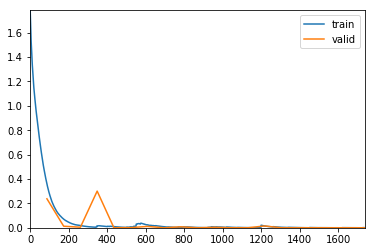

In [3]:
filename = user+"_train_valid.csv"
dataSet = pd.read_csv("data/"+filename)
#dataSet=dataSetIn[0:2000]
rows=dataSet.shape[0]
idx= list(np.random.randint(0,len(dataSet),int(len(dataSet)*0.1)))
data = (TabularList.from_df(dataSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
%time learner.fit_one_cycle(20,1e-2)
#learn.fit(3, 1e-2)
#testSet = pd.read_csv("data/testWithLabels.csv",comment="-")
#resultTest = predict_journeys(learner,testSet)

In [7]:
#learner.metrics[0]
#dataSet.sample(3)
#list(np.random.randint(0,len(dataSet),10))
#list(range(0,20))
#int(len(dataSet)*0.1)
#len(dataSet)
#data
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)


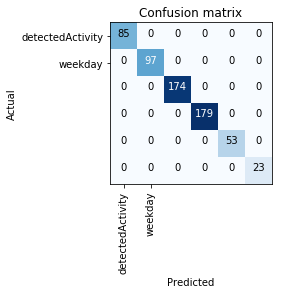

In [8]:
interp.plot_confusion_matrix()

KeyError: tensor(2)

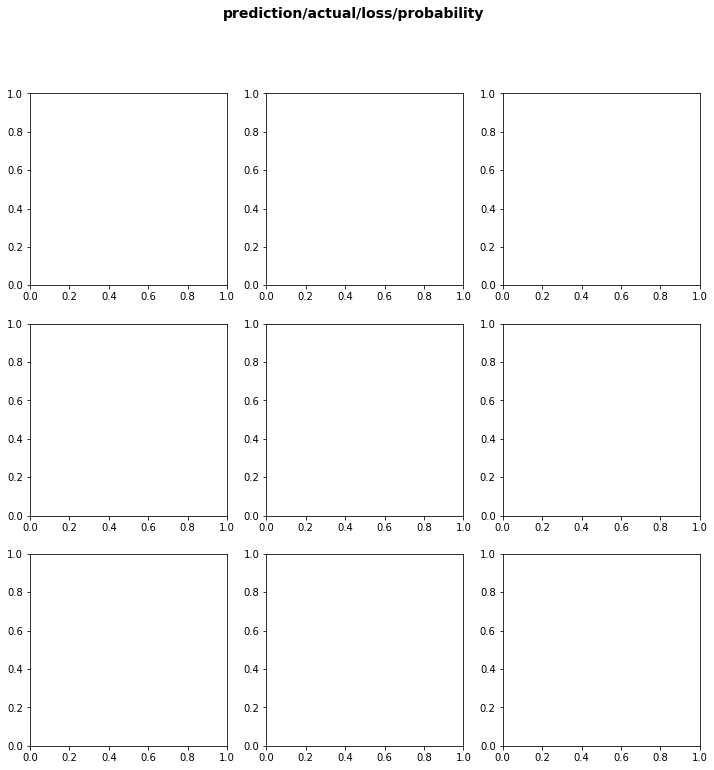

In [15]:
interp.plot_top_losses(9)